# <center> Music Recommender System

We draw inspiration from Spotify's "Discover Weekly" service and aim to recommend a list of songs to each user according to his preference.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
import random
from scipy.stats import norm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time

## Import Data 

In [2]:
df = pd.read_csv("song_data.csv")
df.head()

,user_id,item_id,listening_time_in_scale_0-5,title,duration,loudness,tempo,key,event_type
0,196,242,4.06,Atmosphere Station,191.81669,-38.525,90.084,9,"""Listen it frequently""""View Song Information""""..."
1,63,242,3.24,Atmosphere Station,191.81669,-38.525,90.084,9,"""Listen it frequently""""Like""""View Song Informa..."
2,226,242,3.59,Atmosphere Station,191.81669,-38.525,90.084,9,"""Listen it frequently""""Add it to your music"""
3,154,242,4.34,Atmosphere Station,191.81669,-38.525,90.084,9,"""Listen it frequently""""Like""""View Song Informa..."
4,306,242,4.12,Atmosphere Station,191.81669,-38.525,90.084,9,"""Have listened it completely""""Like""""View Song..."


In [3]:
df['event_type'].value_counts()

"Listen it frequently""Like""View Song Information"                                            2955
"Skip it""Not recommend it anymore"                                                            2915
"Listen it frequently""Download"                                                               2878
"Listen it frequently""View Song Information""Download"                                        2874
"Have listened  it completely""Like""Add it to your music"                                     2851
"Have listened  it completely""Like""Add it to your music""Download"                           2847
"Listen it frequently""Like""Download"                                                         2842
"Listen it frequently""Add it to your music"                                                   2823
"Listen it frequently"                                                                         2822
"Listen it frequently""Like""View Song Information""Add it to your music"                      2815


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   user_id                      100000 non-null  int64  
 1   item_id                      100000 non-null  int64  
 2   listening_time_in_scale_0-5  100000 non-null  float64
 3   title                        100000 non-null  object 
 4   duration                     100000 non-null  float64
 5   loudness                     100000 non-null  float64
 6   tempo                        100000 non-null  float64
 7   key                          100000 non-null  int64  
 8   event_type                   100000 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 6.9+ MB


In [5]:
df['user_id'].value_counts()

405    737
655    685
13     636
450    540
276    518
      ... 
147     20
19      20
572     20
636     20
895     20
Name: user_id, Length: 943, dtype: int64

In [6]:
df['item_id'].value_counts()

50      583
258     509
100     508
181     507
294     485
       ... 
1648      1
1571      1
1329      1
1457      1
1663      1
Name: item_id, Length: 1682, dtype: int64

## Data Preprocessing 

Define strength for each event in 'event_type'

Quantify implicit event feedback 

In [7]:
# event --> strength
event_type_strength = {
    'Listen it frequently': 3.0,
    'Have listened  it completely': 1.0,
    'Like': 1.0,
    'View Song Information': 1.0,
    'Download': 3.0,
    'Add it to your music': 2.0,
    'Skip it':  -1.0, 
    'Skip it frequently': -3.0,
    'Not recommend it anymore': -2.0}

In [8]:
# extract event into a list from a string
df['event_type'] = df['event_type'].apply(lambda x: [e for e in x.split("\"") if len(e)])

# add a column event_strength
df['event_strength'] = df['event_type'].apply(lambda x: np.sum([event_type_strength[e] for e in x]))

In [9]:
# stats on event strength
df['event_strength'].value_counts()

 7.0     14115
 5.0     13980
 6.0     13854
 4.0     13735
 8.0      8337
 3.0      8264
-3.0      5684
 9.0      5531
 2.0      5450
-5.0      2810
-1.0      2761
 1.0      2760
 10.0     2719
Name: event_strength, dtype: int64

In [10]:
df.head()

,user_id,item_id,listening_time_in_scale_0-5,title,duration,loudness,tempo,key,event_type,event_strength
0,196,242,4.06,Atmosphere Station,191.81669,-38.525,90.084,9,"[Listen it frequently, View Song Information, ...",7.0
1,63,242,3.24,Atmosphere Station,191.81669,-38.525,90.084,9,"[Listen it frequently, Like, View Song Informa...",5.0
2,226,242,3.59,Atmosphere Station,191.81669,-38.525,90.084,9,"[Listen it frequently, Add it to your music]",5.0
3,154,242,4.34,Atmosphere Station,191.81669,-38.525,90.084,9,"[Listen it frequently, Like, View Song Informa...",7.0
4,306,242,4.12,Atmosphere Station,191.81669,-38.525,90.084,9,"[Have listened it completely, Like, View Song...",5.0


## Spotify environment 

In [11]:
def random_argmax(rng, list_):
    """ return a random element among max when multiple max exists."""
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

In [12]:
np.set_printoptions(precision=2)

In [13]:
class music_rec_env:
    """ A rating environment that simulates Spotify.
        User and items are represented by points in R^3 modelling song style (loudness, tempo, key) 
        User interest for a given item is modeled by 3 parts:
        1. dot product of user,item embedding vector (cosine similarity, style coherence)
        2. user listening time estimation
        3. user event estimation (event_strength)
        action: Recommend a song list for a given user among those he has never listened to before
    """
    
    def __init__(self, data, seed=None,
                 internal_embedding_size=3,
                 displayed_users_embedding_size=2,
                 displayed_items_embedding_size=2,
                 noise_size=2):
        self.raw_data = data  # pandas dataframe with 'user_id', 'item_id' columns
        self.nb_users = len(df['user_id'].value_counts())
        self.nb_items = len(df['item_id'].value_counts())
        self.internal_embedding_size = internal_embedding_size
        self.displayed_users_embedding_size = displayed_users_embedding_size
        self.displayed_items_embedding_size = displayed_items_embedding_size
        self.noise_size = noise_size
        self._rng = np.random.RandomState(seed)
        
        self.action_size = self.nb_items
        self.sampling_limit = self.nb_users * self.nb_items
        self.users_embedding = None
        self.items_embedding = None
        self.user_item_history = None
        self.done = False

    def step(self, action_list):
        # check if behind done
        if self.done:
            print("Calling step after it returns done=True.\n"
                  "Please reset the environment.")

        # compute potential rewards
        potential_rewards = [self._get_user_item_rating(self.current_user, i) 
                             for i in np.argwhere(self.user_item_history[self.current_user, :] == 0).flatten()]
        
        # compute optimal reward
        optimal_returns = np.array(sorted(potential_rewards, reverse = True))[:len(action_list)]

        # map actions to items
        self.recommended_items = [np.argwhere(self.user_item_history[self.current_user, :] == 0)[action][0] for action in action_list]

        # mark items as rated
        self.user_item_history[self.current_user, self.recommended_items] = 1

        # compute reward R_t
        self.current_ratings = [self._get_user_item_rating(self.current_user, rec_item) for rec_item in self.recommended_items]
        self.rewards = self.current_ratings
        
        # check if done
        if self.user_item_history.sum() == self.sampling_limit:
            self.done = True

        # compute next state S_{t+1}
        self._next_state()

        # update action space t+1
        self.action_size = len(self.available_items)

        return self.rewards, self.state, self.done, optimal_returns

    def reset(self, data=None, seed=None):
        
        if data:
            self.raw_data = data
            
        if seed:
            self._rng = np.random.RandomState(seed)
 
        # create item embedding matrix (song style features) 
        song_df = self.raw_data[['item_id','loudness','tempo','key']].drop_duplicates().sort_values(by = 'item_id')
        style_raw_data = np.vstack((song_df['loudness'], song_df['tempo'],song_df['key'])).T
        min_max_scaler = MinMaxScaler()
        self.items_embedding = min_max_scaler.fit_transform(style_raw_data)
        
        # create user embedding matrix (song style preference features)
        self.users_embedding = np.array([])
        for user in np.array(sorted(self.raw_data['user_id'].unique())):
            user_raw_data = self.raw_data[self.raw_data['user_id']==user]
            tmp = user_raw_data[['loudness','tempo','key']].mul(user_raw_data['listening_time_in_scale_0-5'], axis=0)
            tmp = tmp.div(user_raw_data['listening_time_in_scale_0-5'].sum())
            user_unscaled_data = np.array(tmp.mean(axis=0))
            self.users_embedding = np.append(self.users_embedding, user_unscaled_data)    
        self.users_embedding = min_max_scaler.fit_transform(self.users_embedding.reshape(self.raw_data['user_id'].nunique(),3))    

        # initialize history matrix, recommend history + listening history
        # listening/reocmmend history = 1
        self.user_item_history = np.zeros((self.nb_users, self.nb_items))
        v_func = np.vectorize(self._get_listening_history)
        v_func(a=np.array(self.raw_data['user_id']), b=np.array(self.raw_data['item_id']))
        
        self.done = False

        self._next_state()
        return self.state
     
    def _get_listening_history(self, a, b):
        # record listening history in raw_data
        # a: user_id, b: item_id, M: ndarray
        self.user_item_history[a-1,b-1] = 1  # both id start from 1

    def _get_user_item_rating(self, user, item): 
        # score = style_matching_score + estimated_time_bonus + estimated_event_bonus
        # all 3 parts range from 0 to 1

        # compute style_matching_score
        style_matching_score = self.users_embedding[user].dot(self.items_embedding[item])
        
        user_raw_data = self.raw_data[self.raw_data['user_id']==user]
        songs_similarity = self.items_embedding[np.array(user_raw_data['item_id']),:].dot(self.items_embedding[item])
        
        # compute estimated_time_bonus   
        unscaled_estimated_time_bonuses = user_raw_data['listening_time_in_scale_0-5'].mul(songs_similarity)
        scaled_estimated_time_bonuses = unscaled_estimated_time_bonuses.div(np.sum(songs_similarity))
        estimated_time_bonus = (scaled_estimated_time_bonuses.sum() - user_raw_data['listening_time_in_scale_0-5'].min())/ \
                               (user_raw_data['listening_time_in_scale_0-5'].max() - user_raw_data['listening_time_in_scale_0-5'].min())
        
        # compute estimated_event_bonus
        unscaled_estimated_event_bonuses = user_raw_data['event_strength'].mul(songs_similarity)
        scaled_estimated_event_bonuses = unscaled_estimated_event_bonuses.div(np.sum(songs_similarity))
        estimated_event_bonus = (scaled_estimated_event_bonuses.sum() - user_raw_data['event_strength'].min())/ \
                                (user_raw_data['event_strength'].max() - user_raw_data['event_strength'].min())
        
        score = style_matching_score + estimated_time_bonus + estimated_event_bonus
        return score

    def _get_variables(self, user, item):
        user_embedding = self.users_embedding[user]
        item_embedding = self.items_embedding[item]
        if self.displayed_users_embedding_size + self.displayed_items_embedding_size > 0:
            variables = np.array([user_embedding[:self.displayed_users_embedding_size],
                                  item_embedding[:self.displayed_items_embedding_size]])

            if self.noise_size > 0:
                noise = self._rng.normal(loc=np.zeros(self.noise_size),
                                         scale=np.ones(self.noise_size)/2,
                                         size=self.noise_size)
                variables = np.append(variables, noise)

            return variables

    def _get_new_user(self):
        has_picked = False
        user = self._rng.randint(0, self.nb_users)
        # get a new user who hasn't tried all the songs
        while np.sum(self.user_item_history[user, :]) == self.nb_items:
            user = self._rng.randint(0, self.nb_users)
        return user    

    def _next_state(self):
        # Pick a user
        if self.user_item_history.sum() < self.sampling_limit: 
            self.current_user = self._get_new_user()
        else:
            self.current_user = None

        # list available items
        self.available_items = np.argwhere(self.user_item_history[self.current_user, :] == 0)

        self.state = list()
        for i in self.available_items:
            item = i[0]   
            # compute variables (part of the user, item embedding (with noise))
            variables = self._get_variables(self.current_user, item)
            self.state.append([self.current_user+1, item+1, variables])


In [14]:
env =  music_rec_env(data = df, seed = 2020)

In [15]:
env.reset(seed=2020)[:10]  # user, available_item, user_item_feature with noise

[[865, 2, array([ 0.81,  0.23,  0.78,  0.41,  0.18, -0.51])],
 [865, 3, array([ 0.81,  0.23,  0.8 ,  0.49,  0.05, -0.61])],
 [865, 4, array([ 0.81,  0.23,  0.92,  0.54,  0.99, -0.04])],
 [865, 5, array([ 0.81,  0.23,  0.79,  0.61, -0.42,  0.09])],
 [865, 6, array([ 0.81,  0.23,  0.57,  0.46, -0.13,  0.91])],
 [865, 8, array([ 0.81,  0.23,  0.68,  0.36, -0.2 , -0.01])],
 [865, 9, array([ 0.81,  0.23,  0.86,  0.47,  0.03, -1.32])],
 [865, 10, array([ 0.81,  0.23,  0.77,  0.61, -0.62, -0.79])],
 [865, 11, array([ 0.81,  0.23,  0.84,  0.49, -0.15, -0.56])],
 [865, 12, array([ 0.81,  0.23,  0.86,  0.54,  0.4 , -0.29])]]

In [16]:
np.array(sorted(df[df['user_id']==865]['item_id']))[:10]

array([  1,   7,  21,  24,  71,  91,  95,  99, 100, 101])

User 865 is connecting to the platform.

Recommend him three songs among all available songs.

For each user-item pair, observe also a vector of features that depends on the user, the song and/or some context(like occasion, weather, user's emotion, etc).

In [17]:
reward, next_state, done, optimal_return = env.step(np.arange(3)) # pick the first 3 available items in the list 
print('reward: ', reward)
print('best reward:',optimal_return)

reward:  [2.1523058678879305, 2.004570737665477, 2.159392800121681]
best reward: [2.44 2.44 2.43]


In [18]:
next_state[:10]

[[168, 2, array([ 0.81,  0.2 ,  0.78,  0.41,  0.07, -0.51])],
 [168, 3, array([ 0.81,  0.2 ,  0.8 ,  0.49, -0.23, -0.25])],
 [168, 4, array([0.81, 0.2 , 0.92, 0.54, 0.04, 0.56])],
 [168, 5, array([0.81, 0.2 , 0.79, 0.61, 0.1 , 0.94])],
 [168, 6, array([0.81, 0.2 , 0.57, 0.46, 0.1 , 0.07])],
 [168, 8, array([ 0.81,  0.2 ,  0.68,  0.36,  0.45, -0.48])],
 [168, 10, array([ 0.81,  0.2 ,  0.77,  0.61,  0.1 , -0.01])],
 [168, 11, array([ 0.81,  0.2 ,  0.84,  0.49, -0.1 , -0.19])],
 [168, 12, array([0.81, 0.2 , 0.86, 0.54, 0.27, 0.45])],
 [168, 13, array([ 0.81,  0.2 ,  0.83,  0.57,  1.11, -0.7 ])]]

In [19]:
np.array(sorted(df[df['user_id']==637]['item_id']))[:10]

array([  1,   7,   9,  13,  15,  24,  25,  50,  93, 100])

In [20]:
env.reset(seed=2000)[:10]
reward, next_state, done, optimal_return = env.step(np.arange(3)) # pick the first 3 available items in the list 
print('reward: ', reward)
print('best reward:',optimal_return)

reward:  [2.1749069572290747, 2.2196189312467376, 1.9345863326151673]
best reward: [2.64 2.64 2.57]


## Agent

### Random Agent

In [21]:
class Random:
    """ Random agent. """
    def __init__(self, nb_arms, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        
    def act(self, context):
        actions = self._rng.randint(len(context), size = self._nb_arms)  
        return actions
    
    def update(self, context, action, reward):
        pass

In [22]:
random_agent = Random(nb_arms = 3, seed=0)

## Experiment

In [27]:
def run_exp(agent, env, nb_steps, nb_arms, env_seed):
    rewards_list = np.zeros((nb_steps, nb_arms))
    regrets_list = np.zeros((nb_steps, nb_arms))
    actions_list = np.zeros((nb_steps, nb_arms))
    context = env.reset(data = None, seed = env_seed)

    for i in range(nb_steps):
        # Select action from agent policy.
        actions = agent.act(context)
        
        # Play action in the environment and get reward.
        rewards, next_context, done, optimal_return = env.step(actions)
        
        # Update history
        user = context[0][0]
        items = np.array([context[a][1] for a in actions])  # a list of [user_id, item_id, ]
        rating = rewards
        
        # Update agent.
        agent.update(context, actions, rewards)
        context = next_context
        
        # Save history.
        rewards_list[i] = rewards
        actions_list[i] = actions
        regrets_list[i] = optimal_return - rewards

    reward = np.sum(rewards_list, axis = 0)
    regret = np.sum(regrets_list, axis = 0)
 
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards_list,
            'regrets': regrets_list,
            'actions': actions_list,
            'cum_rewards': np.cumsum(rewards_list, axis = 0), 
            'cum_regrets': np.cumsum(regrets_list, axis = 0)
            }


In [28]:
res = run_exp(random_agent, env, nb_steps=5, nb_arms=3, env_seed=0)

In [29]:
res

{'reward': array([10.56, 10.59, 10.  ]),
 'regret': array([1.54, 1.51, 1.94]),
 'rewards': array([[2.35, 2.04, 2.05],
        [2.13, 2.29, 2.04],
        [2.04, 2.15, 1.89],
        [1.94, 1.99, 1.92],
        [2.1 , 2.13, 2.11]]),
 'regrets': array([[0.41, 0.72, 0.61],
        [0.29, 0.14, 0.37],
        [0.38, 0.27, 0.5 ],
        [0.26, 0.22, 0.29],
        [0.19, 0.17, 0.18]]),
 'actions': array([[1510.,  551.,   87.],
        [ 174.,  849.,  537.],
        [ 845.,   72.,  777.],
        [ 916.,  115.,  755.],
        [1455.,  448.,  850.]]),
 'cum_rewards': array([[ 2.35,  2.04,  2.05],
        [ 4.48,  4.32,  4.09],
        [ 6.52,  6.47,  5.98],
        [ 8.46,  8.46,  7.9 ],
        [10.56, 10.59, 10.  ]]),
 'cum_regrets': array([[0.41, 0.72, 0.61],
        [0.7 , 0.86, 0.98],
        [1.08, 1.13, 1.48],
        [1.35, 1.35, 1.77],
        [1.54, 1.51, 1.94]])}

## Draw empirical regret and confidence bound

In [30]:
def draw_regret_bound(agent_name, nb_arms=3, nb_exp=10, nb_steps=10):
    '''
    Repeat environment-agent interations and draw regret bound for a given agent
    '''    
    regret = np.zeros(nb_exp)
    regrets = np.zeros((nb_exp, nb_steps))
    for i in range(nb_exp):
        env = music_rec_env(data = df, seed = i)
        if agent_name == 'random':
            agent = Random(nb_arms, seed=i)
        exp = run_exp(agent, env, nb_steps, nb_arms, env_seed=2*i)
        regret[i] = np.sum(exp['regret'])
        regrets[i] = np.sum(exp['cum_regrets'], axis = 1) 
        
    plt.plot(regrets.mean(axis=0), color='blue')
    plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
    plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
    plt.title('Mean regret: {:.2f}'.format(regret.mean()))
    plt.xlabel('steps')
    plt.ylabel('regret')
    plt.show()    

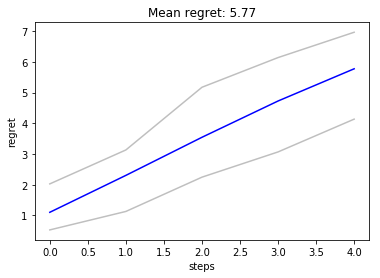

In [31]:
t1 = time.perf_counter()
draw_regret_bound('random', nb_arms=3, nb_exp=10, nb_steps=5)
t2 = time.perf_counter()

In [32]:
t2-t1 # running time in seconds

206.0499343428502